In [26]:
# uncomment this block for google colab
# !pip install psyneulink
!pip install stroop 
!pip install seaborn

In [68]:
import os
import time
import numpy as np
import psyneulink as pnl 

import stroop
from stroop.stimulus import get_stimulus_set, TASKS, COLORS, CONDITIONS

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

sns.set(style='white', context='talk', palette="colorblind")
np.random.seed(0)

%matplotlib inline 
%autosave 5

Autosaving every 5 seconds


In [69]:
# constants
experiment_info = f"""
stroop experiment info
- all colors:\t {COLORS}
- all words:\t {COLORS}
- all tasks:\t {TASKS}
- all conditions:{CONDITIONS}
"""
print(experiment_info)

# calculate experiment metadata
n_conditions = len(CONDITIONS)
n_tasks = len(TASKS)
n_colors = len(COLORS)

# OTHER CONSTANTS
N_UNITS = 2


stroop experiment info
- all colors:	 ['red', 'green']
- all words:	 ['red', 'green']
- all tasks:	 ['color naming', 'word reading']
- all conditions:['control', 'conflict', 'congruent']



## Set up the model

In [67]:
'''define the stroop model'''

def object_function(x):
    
    return (x[0] * x[2] - x[1] * x[3])/(x[4])

def power_func(input=1,power=2):
    
    return input ** power


def get_stroop_model(unit_noise_std=.01, dec_noise_std=.1):
    # model params
    integration_rate = 1
    
    hidden_func = pnl.Logistic(gain=1.0, x_0=4.0)

    # input layer, color and word
    reward = pnl.TransferMechanism(name='reward')
    
    punish = pnl.TransferMechanism(name='punish')
    
    inp_clr = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='COLOR INPUT'
    )
    inp_wrd = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='WORD INPUT'
    )
    # task layer, represent the task instruction; color naming / word reading
    inp_task = pnl.TransferMechanism(
        size=N_UNITS, function=pnl.Linear, name='TASK'
    )
    # hidden layer for color and word
    hid_clr = pnl.TransferMechanism(
        size=N_UNITS,
        function=hidden_func,
        integrator_mode=True,
        integration_rate=integration_rate,
        noise=pnl.NormalDist(standard_deviation=unit_noise_std).function,
        name='COLORS HIDDEN'
    )
    hid_wrd = pnl.TransferMechanism(
        size=N_UNITS,
        function=hidden_func,
        integrator_mode=True,
        integration_rate=integration_rate,
        noise=pnl.NormalDist(standard_deviation=unit_noise_std).function,
        name='WORDS HIDDEN'
    )
    # output layer
    output = pnl.TransferMechanism(
        size=N_UNITS,
        function=pnl.Logistic,
        integrator_mode=True,
        integration_rate=integration_rate,
        noise=pnl.NormalDist(standard_deviation=unit_noise_std).function,
        name='OUTPUT'
    )
    # decision layer, some accumulator
    
    signalSearchRange = pnl.SampleSpec(start=0.05, stop=5, step=0.05)
    
    decision = pnl.DDM(name='Decision',
                       input_format=pnl.ARRAY,
                       function=pnl.DriftDiffusionAnalytical(drift_rate=1,
                                                             threshold =1,
                                                             noise=1,
                                                             starting_point=0,
                                                             t0=0.35),
                       output_ports=[pnl.RESPONSE_TIME,
                                     pnl.PROBABILITY_UPPER_THRESHOLD,
                                     pnl.PROBABILITY_LOWER_THRESHOLD]
                       )
    
    driftrate_control_signal = pnl.ControlSignal(projections=[(pnl.SLOPE, inp_clr)],
                                                 variable=1.0,
                                                 intensity_cost_function=pnl.Exponential(rate=1),#pnl.Exponential(rate=0.8),#pnl.Exponential(rate=1),
                                                 allocation_samples=signalSearchRange)
    
    
    threshold_control_signal = pnl.ControlSignal(projections=[(pnl.THRESHOLD, decision)],
                                                 variable=1.0,
                                                 intensity_cost_function=pnl.Linear(slope=0),
                                                 allocation_samples=signalSearchRange)
    

    
    objective_mech = pnl.ObjectiveMechanism(function=object_function,
                                            monitor=[reward,
                                                     punish,
                                                     decision.output_ports[pnl.PROBABILITY_UPPER_THRESHOLD],
                                                     decision.output_ports[pnl.PROBABILITY_LOWER_THRESHOLD],
                                                     (decision.output_ports[pnl.RESPONSE_TIME])])
    
    

    # PROJECTIONS, weights copied from cohen et al (1990)
    wts_clr_ih = pnl.MappingProjection(
        matrix=[[2.2, -2.2], [-2.2, 2.2]], name='COLOR INPUT TO HIDDEN')
    wts_wrd_ih = pnl.MappingProjection(
        matrix=[[2.6, -2.6], [-2.6, 2.6]], name='WORD INPUT TO HIDDEN')
    wts_clr_ho = pnl.MappingProjection(
        matrix=[[1.3, -1.3], [-1.3, 1.3]], name='COLOR HIDDEN TO OUTPUT')
    wts_wrd_ho = pnl.MappingProjection(
        matrix=[[2.5, -2.5], [-2.5, 2.5]], name='WORD HIDDEN TO OUTPUT')
    wts_tc = pnl.MappingProjection(
        matrix=[[4.0, 4.0], [0, 0]], name='COLOR NAMING')
    wts_tw = pnl.MappingProjection(
        matrix=[[0, 0], [4.0, 4.0]], name='WORD READING')
        
        
    # build the model
    model = pnl.Composition(name='STROOP model')
    
    model.add_node(decision, required_roles=pnl.NodeRole.OUTPUT)
    model.add_node(reward, required_roles=pnl.NodeRole.OUTPUT)
    model.add_node(punish, required_roles=pnl.NodeRole.OUTPUT)
    
    
    model.add_linear_processing_pathway([inp_clr, wts_clr_ih, hid_clr])
    model.add_linear_processing_pathway([inp_wrd, wts_wrd_ih, hid_wrd])
    model.add_linear_processing_pathway([hid_clr, wts_clr_ho, output])
    model.add_linear_processing_pathway([hid_wrd, wts_wrd_ho, output])
    model.add_linear_processing_pathway([inp_task, wts_tc, hid_clr])
    model.add_linear_processing_pathway([inp_task, wts_tw, hid_wrd])
    model.add_linear_processing_pathway([output, pnl.IDENTITY_MATRIX, decision])
    
    controller = pnl.OptimizationControlMechanism(agent_rep=model,
                                                  features=[inp_clr.input_port,
                                                            inp_wrd.input_port,
                                                            inp_task.input_port,
                                                            reward.input_port,
                                                            punish.input_port],
                                                  feature_function=pnl.AdaptiveIntegrator(rate=0.1),
                                                  objective_mechanism=objective_mech,
                                                  function=pnl.GridSearch(),
                                                  control_signals=[driftrate_control_signal,
                                                                   threshold_control_signal])

    model.add_controller(controller=controller)
    
    # collect the node handles
    nodes = [inp_clr, inp_wrd, inp_task, hid_clr, hid_wrd, output, decision, reward, punish,controller]
    metadata = [integration_rate, dec_noise_std, unit_noise_std]
    return model, nodes, metadata

In [65]:
"""
get the stroop model 
"""
# turn off noise
unit_noise_std = 0
dec_noise_std = 0

# define the model 
model, nodes, model_params = get_stroop_model(unit_noise_std, dec_noise_std)

# fetch the params 
[integration_rate, dec_noise_std, unit_noise_std] = model_params
[inp_color, inp_word, inp_task, hid_color, hid_word, output, decision, reward, punish, controller] = nodes

/Users/xleng/Documents/pnl/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/xleng/Documents/pnl/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/xleng/Documents/pnl/lib/python3.7/site-packages/psyneulink-0.7.4.0+20.gd8d5c7c2e-py3.7.egg/psyneulink/core/components/functions/optimizationfunctions.py:488: UserWarning: The following arg(s) were not specified for GridSearch Function-9: objective_function -- using default(s)
  format(self.name, ', '.join(self._unspecified_args)))


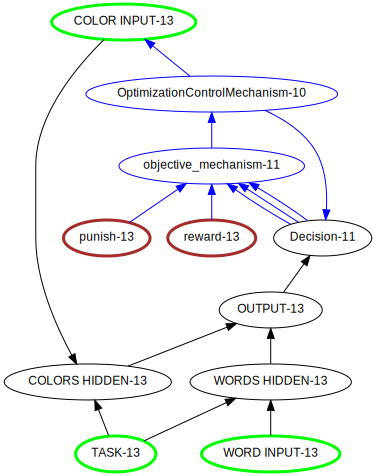

In [66]:
model.show_graph(output_fmt = 'jupyter',show_controller=True)

## Input for the model 

In [85]:
model.enable_controller = True

input_reward_list = [10,20,30]
input_punish_list = [10,20,30]

stim_dict_list = []

for input_reward in input_reward_list:
    for input_punish in input_punish_list:
        
        input_set = get_stimulus_set(inp_color, inp_word, inp_task, 1)

        stim_dict_list.append({inp_color: input_set['color naming']['conflict'][inp_color],
                               inp_word:  input_set['color naming']['conflict'][inp_word],
                               inp_task:  input_set['color naming']['conflict'][inp_task],
                               reward:    input_reward,
                               punish:    input_punish})

In [86]:
 stim_dict_list

[{(TransferMechanism COLOR INPUT-13): array([[1, 0]]),
  (TransferMechanism WORD INPUT-13): array([[0, 1]]),
  (TransferMechanism TASK-13): array([[1, 0]]),
  (TransferMechanism reward-13): 10,
  (TransferMechanism punish-13): 10},
 {(TransferMechanism COLOR INPUT-13): array([[1, 0]]),
  (TransferMechanism WORD INPUT-13): array([[0, 1]]),
  (TransferMechanism TASK-13): array([[1, 0]]),
  (TransferMechanism reward-13): 10,
  (TransferMechanism punish-13): 20},
 {(TransferMechanism COLOR INPUT-13): array([[1, 0]]),
  (TransferMechanism WORD INPUT-13): array([[0, 1]]),
  (TransferMechanism TASK-13): array([[1, 0]]),
  (TransferMechanism reward-13): 10,
  (TransferMechanism punish-13): 30},
 {(TransferMechanism COLOR INPUT-13): array([[1, 0]]),
  (TransferMechanism WORD INPUT-13): array([[0, 1]]),
  (TransferMechanism TASK-13): array([[1, 0]]),
  (TransferMechanism reward-13): 20,
  (TransferMechanism punish-13): 10},
 {(TransferMechanism COLOR INPUT-13): array([[1, 0]]),
  (TransferMechan

## Run the model

In [87]:
controller.set_log_conditions('control_allocation')
# run the model 
execution_id = 0
for task in stim_dict_list:
        print(f'Running Reward: {task[reward]} and Punish: {task[punish]} ... ')
        model.run(
            inputs=task,
            num_trials=1,
            context=execution_id
        )
        execution_id += 1

Running Reward: 10 and Punish: 10 ... 


KeyboardInterrupt: 